This is a LSTM with dropout model used for sentiment analysis over text on 2 classes. The code is adapdable to more classes

Load data

In [121]:
import pandas as pd
import torch

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


we need to clean the data of html tags and also map the sentiments as numbers 1 and 0

In [122]:
import re

# Function to clean the text
def clean_text(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing any characters that are not letters or spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Lowercasing
    text = text.lower()
    # Removing extra spaces
    text = text.strip()
    return text

# Clean the reviews
df['cleaned_review'] = df['review'].apply(clean_text)

# Label Encoding (1 for positive, 0 for negative)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Display the processed dataframe
df[['cleaned_review', 'label']].head()

,cleaned_review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


if the cleaned_review does not exist in the df map, create it and apply the clean_text to the original review

In [123]:
# Check existing DataFrame columns
print(df.columns)

# If 'cleaned_review' column is missing, recreate it
if 'cleaned_review' not in df.columns:
    df['cleaned_review'] = df['review'].apply(clean_text)
    print("'cleaned_review' column created.")

Index(['review', 'sentiment', 'cleaned_review', 'label'], dtype='object')


now we create out vocabularry, a map with the key as a word and the value as an index, the rnn will only understand numbers

In [124]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization
df['tokens'] = df['cleaned_review'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Building a Vocabulary
all_words = [word for tokens in df['tokens'] for word in tokens]
vocabulary = Counter(all_words)

# Displaying the first few rows of the dataframe with tokens and vocabulary size
df[['cleaned_review', 'tokens']].head(), len(vocabulary)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(                                      cleaned_review  \
 0  one of the other reviewers has mentioned that ...   
 1  a wonderful little production the filming tech...   
 2  i thought this was a wonderful way to spend ti...   
 3  basically theres a family where a little boy j...   
 4  petter matteis love in the time of money is a ...   
 
                                               tokens  
 0  [one, reviewers, mentioned, watching, oz, epis...  
 1  [wonderful, little, production, filming, techn...  
 2  [thought, wonderful, way, spend, time, hot, su...  
 3  [basically, theres, family, little, boy, jake,...  
 4  [petter, matteis, love, time, money, visually,...  ,
 214623)

Mapping Tokens to Indices

In [125]:
word_to_index = {word: i + 1 for i, word in enumerate(vocabulary)}

df['indexed_tokens'] = df['tokens'].apply(lambda x: [word_to_index[word] for word in x if word in word_to_index])
print(df['indexed_tokens'])

0        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1        [143, 144, 145, 146, 147, 148, 149, 150, 151, ...
2        [213, 143, 214, 215, 216, 217, 218, 219, 220, ...
3        [282, 283, 284, 144, 285, 286, 287, 283, 288, ...
4        [327, 328, 329, 216, 330, 331, 332, 304, 333, ...
                               ...                        
49995    [213, 293, 9, 393, 1306, 928, 8075, 539, 13, 2...
49996    [529, 225, 529, 227, 529, 392, 6217, 3284, 798...
49997    [12014, 17608, 73710, 14519, 11663, 22688, 176...
49998    [688, 302, 10778, 367, 4565, 142, 7613, 1, 173...
49999    [1, 9209, 674, 5151, 651, 58, 3364, 3088, 2157...
Name: indexed_tokens, Length: 50000, dtype: object


Padding and Truncating Reviews
we choose a fixed size for the reviews and pad shorter reviews with zeros (or a special padding token) and truncate longer reviews.

In [126]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 200

df['padded_tokens'] = pad_sequences(df['indexed_tokens'], maxlen=MAX_LEN, padding='post', truncating='post').tolist()
print(df['padded_tokens'][0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 5, 16, 17, 18, 19, 20, 9, 21, 22, 23, 24, 25, 26, 27, 24, 28, 29, 30, 31, 32, 19, 33, 34, 35, 36, 37, 5, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 48, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 24, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 90, 96, 90, 97, 98, 99, 100, 13, 6, 101, 102, 15, 103, 104, 105, 81, 106, 107, 108, 109, 5, 110, 111, 58, 112, 113, 19, 19, 114, 115, 116, 117, 118, 119, 120, 117, 121, 122, 123, 124, 125, 126, 127, 128, 120, 129, 51, 130, 84, 131, 132, 133, 51, 134, 4, 5, 135, 136, 137, 138, 139, 123, 140, 141, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Splitting the dataset

In [127]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2)
print(train_data)
print(test_data)

                                                  review sentiment  \
4840   This is a film that everyone should watch. Qui...  positive   
39219  An excellent cast who do their best with an aw...  negative   
958    I had two reasons for watching this swashbuckl...  negative   
44901  This movie is truly one of the worst pieces of...  negative   
16249  I've loved this movie for a LONG time. I hadn'...  positive   
...                                                  ...       ...   
21213  This may not be the worst comedy of all time, ...  negative   
37624  A remake can be successful. An adaptation can ...  negative   
36842  There's something going on in this film direct...  negative   
41882  This movie over does it on the cgi i mean sci-...  negative   
49700  Okay, I'll admit the casting in the film is RE...  positive   

                                          cleaned_review  label  \
4840   this is a film that everyone should watch quit...      1   
39219  an excellent cast 

Creating PyTorch DataLoader

In [128]:
import torch
from torch.utils.data import DataLoader, Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)


create datasets

In [129]:
train_dataset = IMDBDataset(train_data['padded_tokens'].tolist(), train_data['label'].tolist())
test_dataset = IMDBDataset(test_data['padded_tokens'].tolist(), test_data['label'].tolist())

create dataloaders

In [130]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

define the model

In [131]:
import torch
import torch.nn as nn

class LSTMDropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.5):
        super(LSTMDropout, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #Transposing x to have the correct shape [sequence_length, batch_size, features]
        x = x.transpose(0, 1)

        # Now the input to LSTM will be [sequence_length, batch_size, embedding_dim]
        embedded = self.dropout(self.embedding(x))

        # The LSTM output will now treat the first dimension as the sequence length
        output, (hidden, cell) = self.lstm(embedded)

        # Use the final hidden state for each batch element
        # hidden[-1] should now correctly give you a tensor of shape [batch_size, hidden_dim]
        hidden = hidden[-1]

        out = self.fc(self.dropout(hidden))
        return out.squeeze()



defiune a train function and eval

In [132]:
import torch

def calculate_accuracy(predictions, labels):
    predicted_classes = torch.argmax(predictions, dim=1)

    correct_predictions = (predicted_classes == labels).float()

    accuracy = correct_predictions.sum() / len(labels)

    return accuracy.item()

def train(model, iterator, iterator_test, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        data, labels = batch
        data, labels = data.to(device), labels.to(device).long()

        optimizer.zero_grad()
        predictions = model(data)

        loss = criterion(predictions, labels)
        acc = calculate_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    train_loss = epoch_loss / len(iterator)
    train_acc = epoch_acc / len(iterator)

    valid_loss, valid_acc = evaluate(model, iterator_test, optimizer, criterion)

    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

    return train_loss, train_acc, valid_loss, valid_acc

def evaluate(model, iterator, optimizer, criterion):
    model.eval()

    with torch.no_grad():
        epoch_loss = 0
        epoch_acc = 0

        for batch in iterator:
            data, labels = batch
            data, labels = data.to(device), labels.to(device).long()

            predictions = model(data)
            loss = criterion(predictions, labels)
            acc = calculate_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc

    valid_loss = epoch_loss / len(iterator)
    valid_acc = epoch_acc / len(iterator)

    return valid_loss, valid_acc



define a plot function

In [133]:
import matplotlib.pyplot as plt

def plot_results(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, valid_accs):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(valid_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

hyperparameters

In [148]:
vocab_size = len(vocabulary) + 1  # +1 for the padding token
embedding_dim = 200  # Size of the word embeddings
hidden_dim = 348  # Size of the hidden states in the LSTM
output_dim = 2  # Binary output (positive or negative)
dropout = 0.13  # Dropout rate (for LSTMDropout model)

# Other parameters
learning_rate = 0.29055
num_epochs = 50  # Number of training epochs
weight_decay = 0.00012

init model

In [149]:
model = LSTMDropout(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)
model.to(device)

LSTMDropout(
  (embedding): Embedding(214624, 200)
  (lstm): LSTM(200, 348, dropout=0.13)
  (dropout): Dropout(p=0.13, inplace=False)
  (fc): Linear(in_features=348, out_features=2, bias=True)
)

In [150]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=0.8795)

In [151]:
# Training loop
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    print("Epoch: " + str(epoch))
    train_loss, train_acc, valid_loss, valid_acc = train(model, train_loader, test_loader, optimizer, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc * 100)
    valid_accs.append(valid_acc * 100)

Epoch: 0
Train Loss: 0.698, Train Acc: 50.25%, Val. Loss: 0.693, Val. Acc: 51.23%
Epoch: 1
Train Loss: 0.694, Train Acc: 50.70%, Val. Loss: 0.693, Val. Acc: 51.28%
Epoch: 2
Train Loss: 0.694, Train Acc: 50.90%, Val. Loss: 0.692, Val. Acc: 51.40%
Epoch: 3
Train Loss: 0.692, Train Acc: 50.64%, Val. Loss: 0.692, Val. Acc: 51.39%
Epoch: 4
Train Loss: 0.691, Train Acc: 51.11%, Val. Loss: 0.694, Val. Acc: 49.68%
Epoch: 5
Train Loss: 0.690, Train Acc: 51.69%, Val. Loss: 0.693, Val. Acc: 51.58%
Epoch: 6
Train Loss: 0.688, Train Acc: 51.66%, Val. Loss: 0.694, Val. Acc: 49.72%
Epoch: 7
Train Loss: 0.686, Train Acc: 51.98%, Val. Loss: 0.694, Val. Acc: 49.62%
Epoch: 8
Train Loss: 0.685, Train Acc: 51.56%, Val. Loss: 0.695, Val. Acc: 50.14%
Epoch: 9
Train Loss: 0.683, Train Acc: 51.76%, Val. Loss: 0.693, Val. Acc: 51.90%
Epoch: 10
Train Loss: 0.681, Train Acc: 52.92%, Val. Loss: 0.694, Val. Acc: 50.12%
Epoch: 11
Train Loss: 0.680, Train Acc: 52.50%, Val. Loss: 0.695, Val. Acc: 50.12%
Epoch: 12
Trai

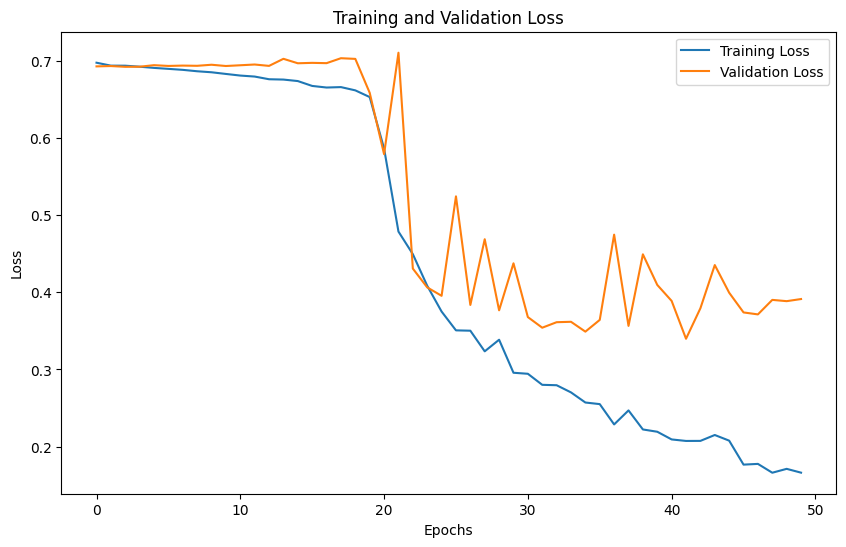

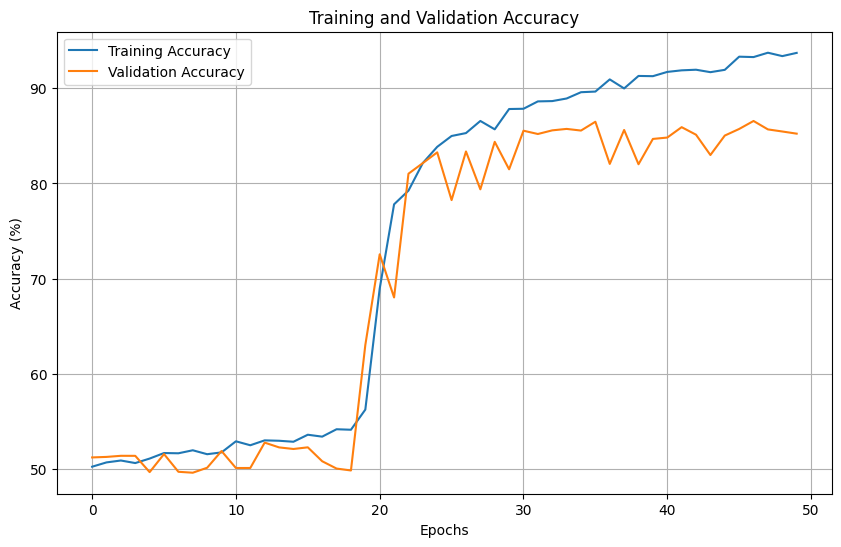

In [152]:
plot_results(train_losses, valid_losses)
plot_accuracy(train_accs, valid_accs)

In [155]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def get_predictions(model, iterator):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            predictions = model(data)
            predicted_classes = torch.argmax(predictions, dim=1)

            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels
predictions, labels = get_predictions(model, test_loader)


In [156]:
report = classification_report(labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.78      0.84      5057
    Positive       0.80      0.93      0.86      4943

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



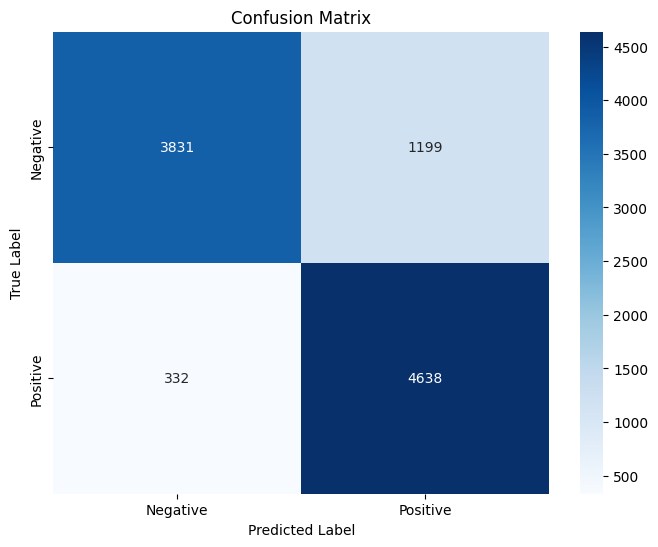

In [157]:
import seaborn as sns

def plot_confusion_matrix(conf_mat):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming you already have conf_mat from the previous steps
plot_confusion_matrix(conf_mat)

se stabilizeaza la epoca 30, 0.3 lr, 0.0001 wd, 0.9 momentum, 50 de epoci, overfitting

30 de epoci e destul